# Importing Libraries

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Displaying signatures

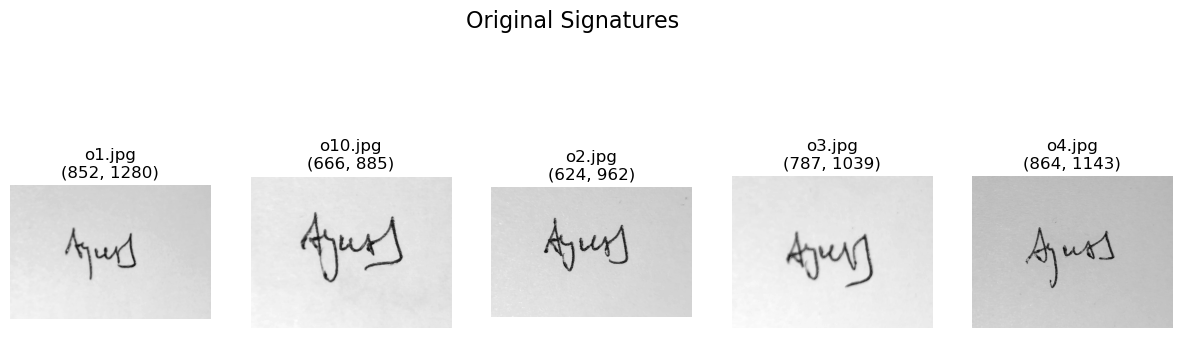

Test Signature Size: (367, 477)


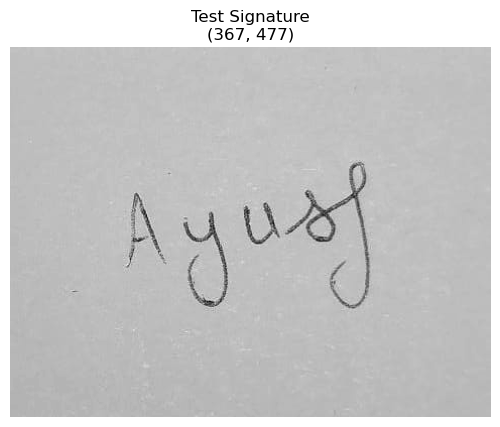

In [23]:
# Path to your dataset
original_signatures_path = "C:/data/dsatm/5th sem/Mini Project/dataset/Mine/original"  # Update this to your folder path
test_signature_path = "C:/data/dsatm/5th sem/Mini Project/dataset/Mine/forged/f2.jpg" # Update this to your test image file path

# Helper function to load images and display their sizes
def load_images_from_folder(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append((img, filename, img.shape))  # Store image, filename, and size
    return images

# Load original and test signatures
original_signatures = load_images_from_folder(original_signatures_path)
test_signature = cv2.imread(test_signature_path, cv2.IMREAD_GRAYSCALE)

# Display some original signatures and their sizes
def display_images_with_sizes(images, title="Original Signatures", rows=1, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5))
    for i in range(min(len(images), rows * cols)):
        img, filename, size = images[i]
        axes[i].imshow(img, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f"{filename}\n{size}")
    fig.suptitle(title, fontsize=16)
    plt.show()

# Show samples and their sizes
display_images_with_sizes(original_signatures, title="Original Signatures")
print(f"Test Signature Size: {test_signature.shape if test_signature is not None else 'Not Loaded'}")
plt.imshow(test_signature, cmap='gray')
plt.title(f"Test Signature\n{test_signature.shape if test_signature is not None else 'N/A'}")
plt.axis("off")
plt.show()


# Pre-processing 

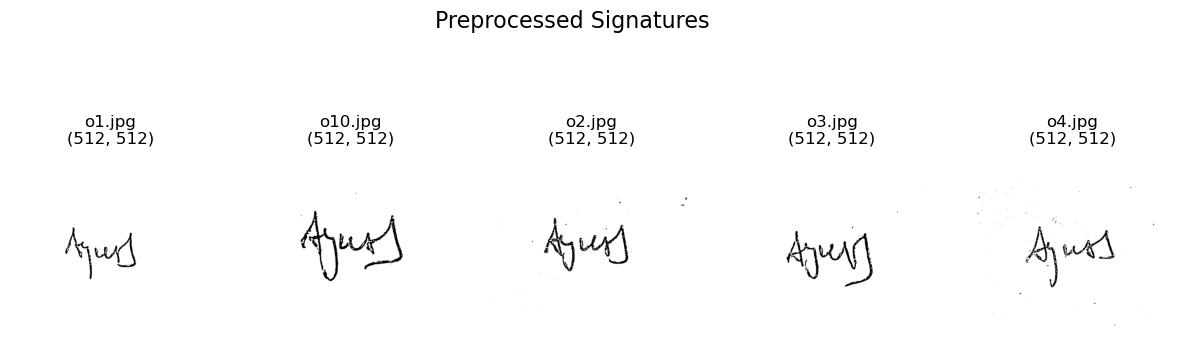

Preprocessed Test Signature Size: (512, 512)


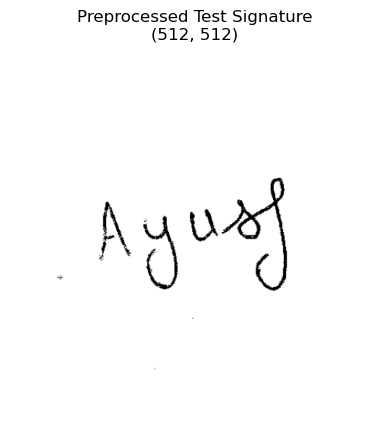

In [24]:
def preprocess_signature(image, resize_dim=(512, 512)):
    """
    Enhanced preprocessing for signature images.
    - Preserves the structure of the signature while standardizing the input format.
    """
    # Convert to grayscale (if not already)
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Bilateral Filter for noise reduction
    filtered_image = cv2.bilateralFilter(image, d=9, sigmaColor=75, sigmaSpace=75)

    # Adaptive Thresholding for binarization
    binary_image = cv2.adaptiveThreshold(
        filtered_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY, blockSize=11, C=2
    )

    # Extract the signature region using contours
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        # Get bounding box of the largest contour
        x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))

        # Add padding to the bounding box
        padding = 10
        x = max(0, x - padding)
        y = max(0, y - padding)
        w += 2 * padding
        h += 2 * padding

        cropped_image = binary_image[y:y+h, x:x+w]
    else:
        # If no contours found, use the whole image
        cropped_image = binary_image

    # Resize with aspect ratio preservation
    h, w = cropped_image.shape
    scale = min(resize_dim[0] / h, resize_dim[1] / w)
    new_h, new_w = int(h * scale), int(w * scale)
    resized_image = cv2.resize(cropped_image, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # Create a blank canvas and center the resized image
    final_image = np.ones(resize_dim, dtype=np.uint8) * 255  # White background
    y_offset = (resize_dim[0] - new_h) // 2
    x_offset = (resize_dim[1] - new_w) // 2
    final_image[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized_image

    return final_image

# Preprocess dataset
def preprocess_dataset(images):
    """
    Preprocesses a dataset of signature images.
    - Applies preprocessing to each image in the dataset.
    """
    preprocessed_images = []
    for img, filename, original_size in images:
        preprocessed_img = preprocess_signature(img)
        resize = preprocessed_img.shape
        preprocessed_images.append((preprocessed_img, filename, resize))
    return preprocessed_images

preprocessed_original_signatures = preprocess_dataset(original_signatures)
preprocessed_test_signature = preprocess_signature(test_signature)

# Display some preprocessed signatures and their sizes
def display_images_with_sizes(images, title="Preprocessed Signatures", rows=1, cols=5):
    """
    Displays preprocessed signature images with their sizes.
    """
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5))
    for i in range(min(len(images), rows * cols)):
        img, filename, size = images[i]
        axes[i].imshow(img, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f"{filename}\n{size}")
    fig.suptitle(title, fontsize=16)
    plt.show()

# Show samples and their sizes
display_images_with_sizes(preprocessed_original_signatures, title="Preprocessed Signatures")
print(f"Preprocessed Test Signature Size: {preprocessed_test_signature.shape if preprocessed_test_signature is not None else 'Not Loaded'}")
plt.imshow(preprocessed_test_signature, cmap='gray')
plt.title(f"Preprocessed Test Signature\n{preprocessed_test_signature.shape if preprocessed_test_signature is not None else 'N/A'}")
plt.axis("off")
plt.show()


# Segmentation

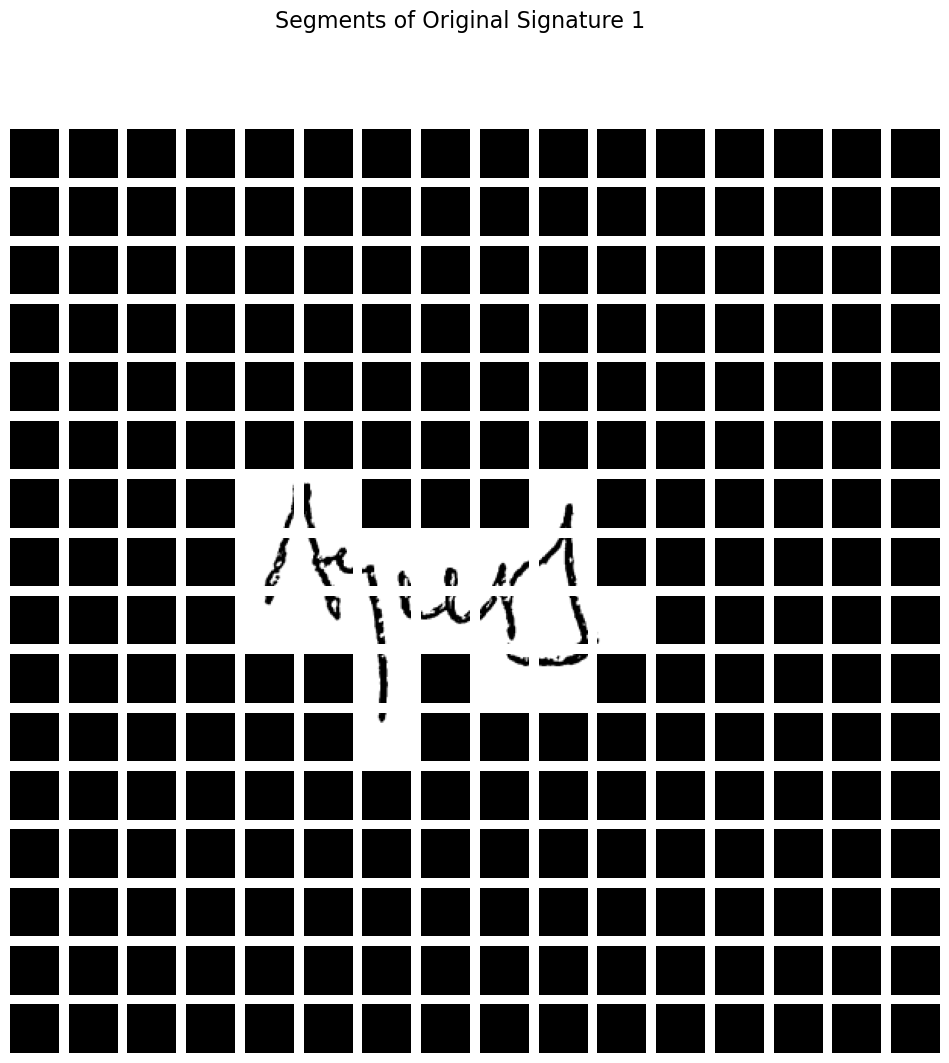

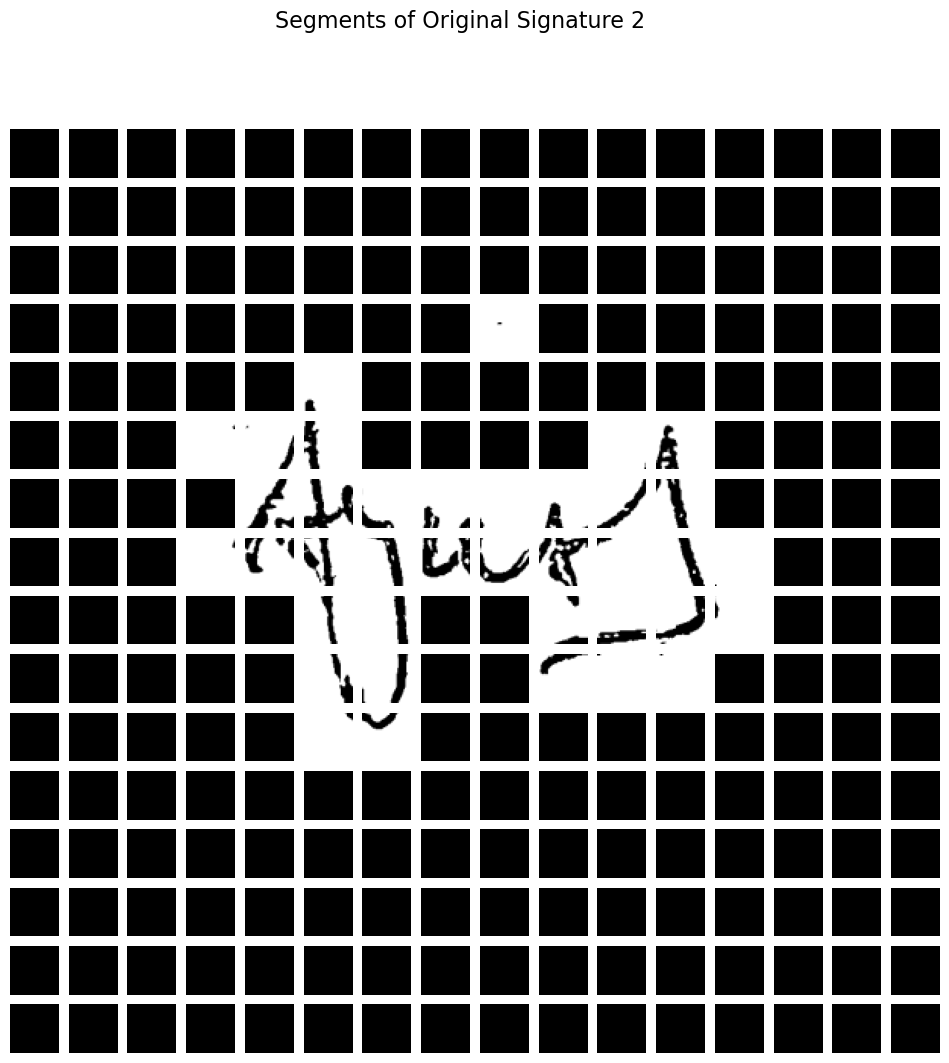

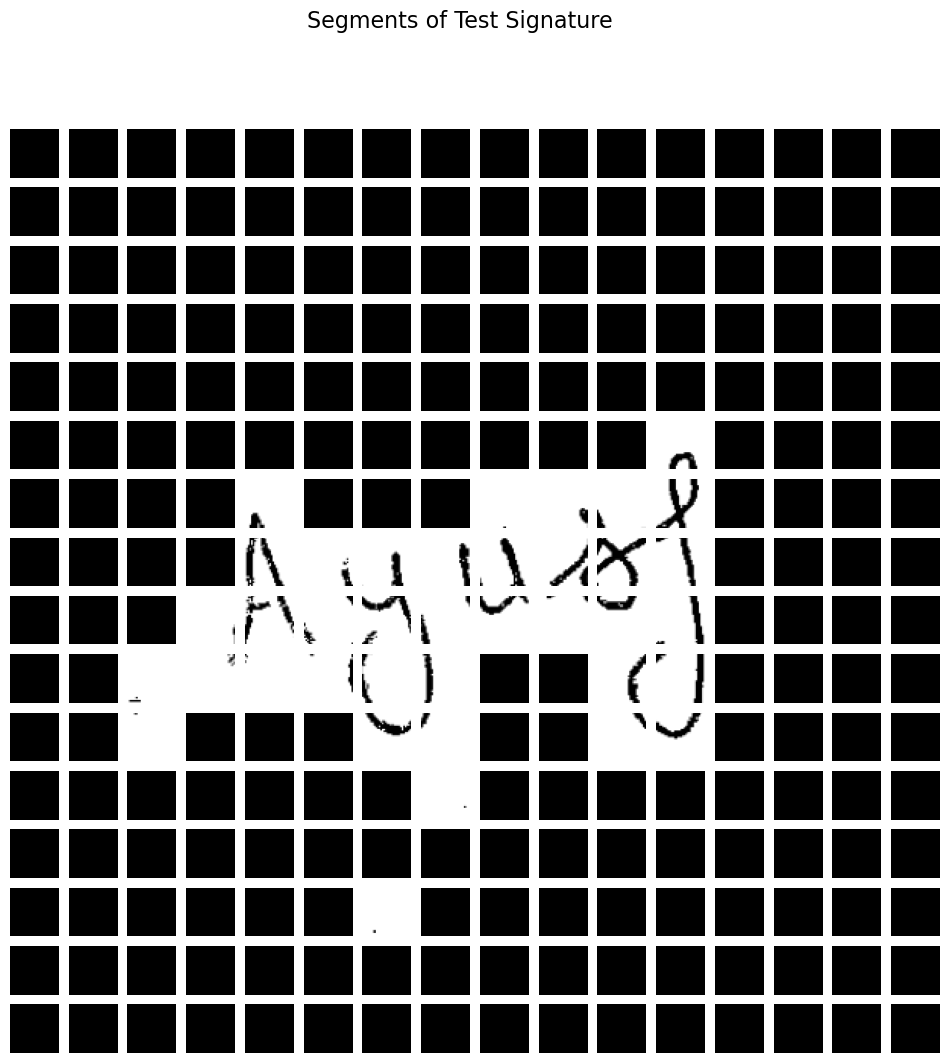

In [25]:
grid_size=(16, 16)
def segment_image(image, grid_size=grid_size):
    h, w = image.shape
    rows, cols = grid_size
    segment_height = h // rows
    segment_width = w // cols
    
    segments = []
    for r in range(rows):
        for c in range(cols):
            segment = image[r * segment_height:(r + 1) * segment_height, c * segment_width:(c + 1) * segment_width]
            segments.append(segment)
    return segments

def segment_dataset(images):
    segmented_images = []
    for img, filename, original_size in images:
        segmented_img = segment_image(img, grid_size=grid_size)
        segmented_images.append(segmented_img)
    return segmented_images

# Segment all preprocessed original signatures with grids
segmented_signatures_16x16 = segment_dataset(preprocessed_original_signatures)

# Segment the preprocessed test signature with grids
segmented_test_signature_16x16 = segment_image(preprocessed_test_signature, grid_size=grid_size)

# Display segments from the first preprocessed original signature
def display_segments(segments, grid_size=grid_size, title="Segments"):
    rows, cols = grid_size
    fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
    for i, ax in enumerate(axes.flat):
        ax.imshow(segments[i], cmap='gray')
        ax.axis('off')
    fig.suptitle(title, fontsize=16)
    plt.show()

# Show segments for the first original signature and the test signature
display_segments(segmented_signatures_16x16[0], grid_size=grid_size, title="Segments of Original Signature 1")
display_segments(segmented_signatures_16x16[1], grid_size=grid_size, title="Segments of Original Signature 2")
display_segments(segmented_test_signature_16x16, grid_size=grid_size, title="Segments of Test Signature")


# Comparison

## Thresholding

In [26]:
from skimage.metrics import structural_similarity as compare_ssim

# Function to calculate MSE between two segments
def calculate_mse(segment1, segment2):
    return np.mean((segment1.astype("float") - segment2.astype("float")) ** 2)

# Function to calculate SSIM between two segments
def calculate_ssim(segment1, segment2):
    smallest_dim = min(segment1.shape[0], segment1.shape[1])
    win_size = min(7, smallest_dim) if smallest_dim >= 7 else smallest_dim
    if win_size % 2 == 0:  # Ensure win_size is odd
        win_size -= 1
    score, _ = compare_ssim(segment1, segment2, full=True, win_size=win_size)
    return score

# Template Matching Function
def calculate_template_match(segment1, segment2):
    if segment1.shape != segment2.shape:
        segment2 = cv2.resize(segment2, (segment1.shape[1], segment1.shape[0]))
    match_result = cv2.matchTemplate(segment1, segment2, cv2.TM_CCOEFF_NORMED)
    return np.max(match_result)

# Histogram Comparison Function
def calculate_histogram_similarity(segment1, segment2):
    hist1 = cv2.calcHist([segment1], [0], None, [256], [0, 256])
    hist2 = cv2.calcHist([segment2], [0], None, [256], [0, 256])
    hist1 = cv2.normalize(hist1, hist1).flatten()
    hist2 = cv2.normalize(hist2, hist2).flatten()
    score = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL)
    return score

from skimage.feature import hog

# Function to calculate HOG similarity between two segments
def calculate_hog_similarity(segment1, segment2):
    # Compute HOG features for both segments
    hog1, _ = hog(segment1, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    hog2, _ = hog(segment2, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)

    # Compute the norms of the HOG feature vectors
    norm1 = np.linalg.norm(hog1)
    norm2 = np.linalg.norm(hog2)

    # Check if any of the norms is zero and handle it
    if norm1 == 0 or norm2 == 0:
        return 0  # Return 0 similarity if one of the vectors is a zero vector

    # Compute the cosine similarity between the two HOG feature vectors
    score = np.dot(hog1, hog2) / (norm1 * norm2)
    return score

from sklearn.metrics import normalized_mutual_info_score

# Normalized Mutual Information Function
def calculate_nmi(segment1, segment2):
    hist1, _ = np.histogram(segment1.ravel(), bins=256, range=(0, 256))
    hist2, _ = np.histogram(segment2.ravel(), bins=256, range=(0, 256))
    score = normalized_mutual_info_score(hist1, hist2)
    return score

def compare_signature(original_segments_list, test_segments, weights=None, skip_identical=True):
    results = []
    for idx, original_segments in enumerate(original_segments_list):
        if skip_identical and original_segments is test_segments:
            continue
        
        scores = {"mse": [], "ssim": [], "template": [], "histogram": [], "hog": [], "dssim": [], "nmi": []}
        for i in range(len(original_segments)):
            if np.array_equal(original_segments[i], test_segments[i]):
                continue

            mse_score = calculate_mse(original_segments[i], test_segments[i])
            scores["mse"].append(1 / (1 + mse_score))  # Normalize MSE

            ssim_score = calculate_ssim(original_segments[i], test_segments[i])
            scores["ssim"].append(ssim_score)

            template_score = calculate_template_match(original_segments[i], test_segments[i])
            scores["template"].append(template_score)

            hist_score = calculate_histogram_similarity(original_segments[i], test_segments[i])
            scores["histogram"].append(hist_score)

            hog_score = calculate_hog_similarity(original_segments[i], test_segments[i])
            scores["hog"].append(hog_score)

            nmi_score = calculate_nmi(original_segments[i], test_segments[i])
            scores["nmi"].append(nmi_score)

        mse_avg = np.average(scores["mse"], weights=weights)
        ssim_avg = np.average(scores["ssim"], weights=weights)
        template_avg = np.average(scores["template"], weights=weights)
        histogram_avg = np.average(scores["histogram"], weights=weights)
        hog_avg = np.average(scores["hog"], weights=weights)
        nmi_avg = np.average(scores["nmi"], weights=weights)

        results.append({
            "mse_avg": mse_avg,
            "ssim_avg": ssim_avg,
            "template_avg": template_avg,
            "histogram_avg": histogram_avg,
            "hog_avg": hog_avg,
            "nmi_avg": nmi_avg,
        })
    
    return results


mse_scores, ssim_scores, temp_scores, hist_scores, hog_scores, nmi_scores=[],[],[],[],[],[]

for i in range(len(segmented_signatures_16x16)):
    print(f"Comparison with Original Signature {i + 1}")
    comparison_results = compare_signature(
        original_segments_list=segmented_signatures_16x16,
        test_segments=segmented_signatures_16x16[i],  # Replace for meaningful comparisons
        weights=None,
        skip_identical=True
    )

    for idx, result in enumerate(comparison_results):
        print(
            f"Original Signature {idx + 1}: "
            f"MSE = {result['mse_avg']:.4f}, "
            f"SSIM = {result['ssim_avg']:.4f}, "
            f"Template Match = {result['template_avg']:.4f}, "
            f"Histogram = {result['histogram_avg']:.4f}, "
            f"HOG = {result['hog_avg']:.4f}, "
            f"NMI = {result['nmi_avg']:.4f}"
        )


    mse = np.mean([result['mse_avg'] for result in comparison_results])
    ssim = np.mean([result['ssim_avg'] for result in comparison_results])
    temp = np.mean([result['template_avg'] for result in comparison_results])
    hist = np.mean([result['histogram_avg'] for result in comparison_results])
    hogs = np.mean([result['hog_avg'] for result in comparison_results])
    nmi = np.mean([result['nmi_avg'] for result in comparison_results])

    print(
        f"Average Scores:\n"
        f"MSE: {mse:.4f}, SSIM: {ssim:.4f}, "
        f"Template: {temp:.4f}, Histogram: {hist:.4f}, HOG: {hogs:.4f}, NMI: {nmi:.4f}\n"
    )

    mse_scores.append(mse)
    ssim_scores.append(ssim)
    temp_scores.append(temp)
    hist_scores.append(hist)
    hog_scores.append(hogs)
    nmi_scores.append(nmi)

mse_org_16x16 = np.mean([mse for mse in mse_scores])
ssim_org_16x16 = np.mean([ssim for ssim in ssim_scores])
temp_org_16x16 = np.mean([temp for temp in temp_scores])
hist_org_16x16 = np.mean([hist for hist in hist_scores])
hog_org_16x16 = np.mean([hogs for hogs in hog_scores])
nmi_org_16x16 = np.mean([nmi for nmi in nmi_scores])

original_scores = {
            "mse": mse_org_16x16,
            "ssim": ssim_org_16x16,
            "template": temp_org_16x16,
            "histogram": hist_org_16x16,
            "hog": hog_org_16x16,
            "nmi": nmi_org_16x16,
        }

print(f"MSE Score : {mse_org_16x16:.4f}, SSIM Score : {ssim_org_16x16:.4f}, TM Score : {temp_org_16x16:.4f}, Hist Score : {hist_org_16x16:.4f}, "
      f"HOG Score : {hog_org_16x16:.4f}, NMI Score : {nmi_org_16x16:.4f}\n"
      f"Original scores: {original_scores}")

Comparison with Original Signature 1
Original Signature 1: MSE = 0.0218, SSIM = 0.5945, Template Match = 0.5413, Histogram = 0.9858, HOG = 0.1104, NMI = 0.1492
Original Signature 2: MSE = 0.0611, SSIM = 0.7163, Template Match = 0.6467, Histogram = 0.9953, HOG = 0.1093, NMI = 0.2389
Original Signature 3: MSE = 0.0083, SSIM = 0.5602, Template Match = 0.4105, Histogram = 0.9939, HOG = 0.1798, NMI = 0.1290
Original Signature 4: MSE = 0.1140, SSIM = 0.7970, Template Match = 0.7672, Histogram = 0.9988, HOG = 0.0521, NMI = 0.2669
Original Signature 5: MSE = 0.0329, SSIM = 0.5579, Template Match = 0.3740, Histogram = 0.9969, HOG = 0.1664, NMI = 0.1803
Original Signature 6: MSE = 0.0355, SSIM = 0.6472, Template Match = 0.3329, Histogram = 0.9976, HOG = 0.2144, NMI = 0.2042
Original Signature 7: MSE = 0.0091, SSIM = 0.5413, Template Match = 0.4316, Histogram = 0.9911, HOG = 0.0800, NMI = 0.1189
Original Signature 8: MSE = 0.0406, SSIM = 0.7370, Template Match = 0.7780, Histogram = 0.9890, HOG = 

## Test Comparison

In [29]:
from skimage.metrics import structural_similarity as compare_ssim

# Function to calculate MSE between two segments
def calculate_mse(segment1, segment2):
    return np.mean((segment1.astype("float") - segment2.astype("float")) ** 2)

# Function to calculate SSIM between two segments
def calculate_ssim(segment1, segment2):
    smallest_dim = min(segment1.shape[0], segment1.shape[1])
    win_size = min(7, smallest_dim) if smallest_dim >= 7 else smallest_dim
    if win_size % 2 == 0:  # Ensure win_size is odd
        win_size -= 1
    score, _ = compare_ssim(segment1, segment2, full=True, win_size=win_size)
    return score

# Template Matching Function
def calculate_template_match(segment1, segment2):
    if segment1.shape != segment2.shape:
        segment2 = cv2.resize(segment2, (segment1.shape[1], segment1.shape[0]))
    match_result = cv2.matchTemplate(segment1, segment2, cv2.TM_CCOEFF_NORMED)
    return np.max(match_result)

# Histogram Comparison Function
def calculate_histogram_similarity(segment1, segment2):
    hist1 = cv2.calcHist([segment1], [0], None, [256], [0, 256])
    hist2 = cv2.calcHist([segment2], [0], None, [256], [0, 256])
    hist1 = cv2.normalize(hist1, hist1).flatten()
    hist2 = cv2.normalize(hist2, hist2).flatten()
    score = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL)
    return score

from skimage.feature import hog

# Function to calculate HOG similarity between two segments
def calculate_hog_similarity(segment1, segment2):
    # Compute HOG features for both segments
    hog1, _ = hog(segment1, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    hog2, _ = hog(segment2, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)

    # Compute the norms of the HOG feature vectors
    norm1 = np.linalg.norm(hog1)
    norm2 = np.linalg.norm(hog2)

    # Check if any of the norms is zero and handle it
    if norm1 == 0 or norm2 == 0:
        return 0  # Return 0 similarity if one of the vectors is a zero vector

    # Compute the cosine similarity between the two HOG feature vectors
    score = np.dot(hog1, hog2) / (norm1 * norm2)
    return score

from sklearn.metrics import normalized_mutual_info_score

# Normalized Mutual Information Function
def calculate_nmi(segment1, segment2):
    hist1, _ = np.histogram(segment1.ravel(), bins=256, range=(0, 256))
    hist2, _ = np.histogram(segment2.ravel(), bins=256, range=(0, 256))
    score = normalized_mutual_info_score(hist1, hist2)
    return score

def compare_signature(original_segments_list, test_segments, weights=None, skip_identical=True):
    results = []
    for idx, original_segments in enumerate(original_segments_list):
        if skip_identical and original_segments is test_segments:
            continue
        
        scores = {"mse": [], "ssim": [], "template": [], "histogram": [], "hog": [], "dssim": [], "nmi": []}
        for i in range(len(original_segments)):
            if np.array_equal(original_segments[i], test_segments[i]):
                continue

            mse_score = calculate_mse(original_segments[i], test_segments[i])
            scores["mse"].append(1 / (1 + mse_score))  # Normalize MSE

            ssim_score = calculate_ssim(original_segments[i], test_segments[i])
            scores["ssim"].append(ssim_score)

            template_score = calculate_template_match(original_segments[i], test_segments[i])
            scores["template"].append(template_score)

            hist_score = calculate_histogram_similarity(original_segments[i], test_segments[i])
            scores["histogram"].append(hist_score)

            hog_score = calculate_hog_similarity(original_segments[i], test_segments[i])
            scores["hog"].append(hog_score)

            nmi_score = calculate_nmi(original_segments[i], test_segments[i])
            scores["nmi"].append(nmi_score)

        mse_avg = np.average(scores["mse"], weights=weights)
        ssim_avg = np.average(scores["ssim"], weights=weights)
        template_avg = np.average(scores["template"], weights=weights)
        histogram_avg = np.average(scores["histogram"], weights=weights)
        hog_avg = np.average(scores["hog"], weights=weights)
        nmi_avg = np.average(scores["nmi"], weights=weights)

        results.append({
            "mse_avg": mse_avg,
            "ssim_avg": ssim_avg,
            "template_avg": template_avg,
            "histogram_avg": histogram_avg,
            "hog_avg": hog_avg,
            "nmi_avg": nmi_avg,
        })
    
    return results


comparison_results = compare_signature(
        original_segments_list=segmented_signatures_16x16,
        test_segments=segmented_test_signature_16x16,  # Replace for meaningful comparisons
        weights=None,
        skip_identical=True
    )

for idx, result in enumerate(comparison_results):
        print(
            f"Original Signature {idx + 1}: "
            f"MSE = {result['mse_avg']:.4f}, "
            f"SSIM = {result['ssim_avg']:.4f}, "
            f"Template Match = {result['template_avg']:.4f}, "
            f"Histogram = {result['histogram_avg']:.4f}, "
            f"HOG = {result['hog_avg']:.4f}, "
            f"NMI = {result['nmi_avg']:.4f}"
        )


mse_test = np.mean([result['mse_avg'] for result in comparison_results])
ssim_test = np.mean([result['ssim_avg'] for result in comparison_results])
temp_test = np.mean([result['template_avg'] for result in comparison_results])
hist_test = np.mean([result['histogram_avg'] for result in comparison_results])
hogs_test = np.mean([result['hog_avg'] for result in comparison_results])
nmi_test = np.mean([result['nmi_avg'] for result in comparison_results])

test_scores = {
            "mse": mse_test,
            "ssim": ssim_test,
            "template": temp_test,
            "histogram": hist_test,
            "hog": hogs_test,
            "nmi": nmi_test,
        }

print(
        f"Average Scores:\n"
        f"MSE: {mse_test:.4f}, SSIM: {ssim_test:.4f}, "
        f"Template: {temp_test:.4f}, Histogram: {hist_test:.4f}, HOG: {hogs_test:.4f}, NMI: {nmi_test:.4f}\n"
        f"Test scores: {test_scores}")

Original Signature 1: MSE = 0.0209, SSIM = 0.6178, Template Match = 0.0560, Histogram = 0.9929, HOG = 0.0542, NMI = 0.1365
Original Signature 2: MSE = 0.0176, SSIM = 0.6320, Template Match = 0.3028, Histogram = 0.9868, HOG = 0.0978, NMI = 0.1511
Original Signature 3: MSE = 0.0454, SSIM = 0.7036, Template Match = 0.4133, Histogram = 0.9932, HOG = 0.0626, NMI = 0.2158
Original Signature 4: MSE = 0.0250, SSIM = 0.5904, Template Match = 0.1450, Histogram = 0.9917, HOG = 0.1231, NMI = 0.1537
Original Signature 5: MSE = 0.0943, SSIM = 0.7794, Template Match = 0.6135, Histogram = 0.9969, HOG = 0.0391, NMI = 0.2458
Original Signature 6: MSE = 0.0409, SSIM = 0.6342, Template Match = 0.1560, Histogram = 0.9958, HOG = 0.1198, NMI = 0.1707
Original Signature 7: MSE = 0.0413, SSIM = 0.6888, Template Match = 0.2020, Histogram = 0.9934, HOG = 0.0878, NMI = 0.1837
Original Signature 8: MSE = 0.0027, SSIM = 0.5851, Template Match = 0.1630, Histogram = 0.9929, HOG = 0.0829, NMI = 0.1210
Original Signatu

# Confidence Score Calculation

In [30]:
diff = {}
print("Original Scores:",original_scores,"\nTest Scores:",test_scores)
for metric in test_scores:
    diff[metric] = original_scores[metric] - test_scores[metric]
print("\nTest Difference:",diff)

# Check if three or more values in the test dictionary are positive
count = sum(1 for value in diff.values() if value > 0)

# Determine if the signature is forged
if count > 3:
    print("Signature is forged.")
else:
    print("Signature is genuine.")

Original Scores: {'mse': 0.04957330406665776, 'ssim': 0.6772421902363337, 'template': 0.3175869, 'histogram': 0.9931799908439466, 'hog': 0.09833369408498364, 'nmi': 0.20371527924862395} 
Test Scores: {'mse': 0.03582435407746156, 'ssim': 0.6598135642761133, 'template': 0.28878683, 'histogram': 0.9928620641635822, 'hog': 0.080601829476837, 'nmi': 0.17556336228061914}

Test Difference: {'mse': 0.0137489499891962, 'ssim': 0.017428625960220434, 'template': 0.02880007, 'histogram': 0.00031792668036434435, 'hog': 0.017731864608146644, 'nmi': 0.028151916968004814}
Signature is forged.
